In [1]:
import cv2
from skimage.color import rgb2lab, lab2rgb, rgb2gray, gray2rgb
import matplotlib.pyplot as plt 
from skimage.transform import resize
from skimage.io import imsave
import numpy as np
from tensorflow.keras.layers import RepeatVector , Reshape 
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import os

In [3]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, decode_predictions, preprocess_input
inception = InceptionResNetV2(weights=None, include_top=True)
inception.load_weights('./data/inception_resnet_v2_weights_tf_dim_ordering_tf_kernels.h5')
inception.graph = tf.get_default_graph()

Instructions for updating:
non-resource variables are not supported in the long term


In [4]:
#To generate embeddings of 1000*1 by passing input images through InceptionResNetV2
def create_inception_embedding(grayscaled_rgb):
    grayscaled_rgb_resized = []
    for i in grayscaled_rgb:
        i = resize(i, (299, 299, 3), mode='constant')
        grayscaled_rgb_resized.append(i)
    grayscaled_rgb_resized = np.array(grayscaled_rgb_resized)
    grayscaled_rgb_resized = preprocess_input(grayscaled_rgb_resized)
    with inception.graph.as_default():
        embed = inception.predict(grayscaled_rgb_resized)
    return embed
import tensorflow as tf

In [5]:
from tensorflow import keras
model = keras.models.load_model('./color_model_V5.h5')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [6]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 640         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 128 73856       conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 64, 64, 128)  147584      conv2d_1[0][0]                   
______________________________________________________________________________________________

In [7]:
# Util functions

def lab2RGB(l, ab):
    shape = (l.shape[0],l.shape[1],3)
    img = np.zeros(shape)
    img[:,:,0] = l[:,:,0]
    img[:,:,1:] = ab
    img = img.astype('uint8')
    print(img.max())
    img = cv2.cvtColor(img, cv2.COLOR_LAB2RGB)
    return img
def display(img):
    plt.figure()
    plt.set_cmap('gray')
    plt.imshow(img)
    plt.show()

def get_RGB(image_l, image_ab  ):
       
    image_l = image_l.reshape((256, 256, 1))
    image_lab = np.concatenate((image_l, image_ab), axis=2)
    image_lab = image_lab.astype("uint8")
 
    image_rgb = cv2.cvtColor(image_lab, cv2.COLOR_LAB2RGB)
    image_rgb = Image.fromarray(image_rgb)
    return image_rgb





In [13]:
def get_rgb_prediction(img_path):
    test_img = cv2.imread(img_path)
    rgb_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
    print (rgb_img.shape)

    display(rgb_img)

    img_lab = rgb2lab(test_img)
    img_lab = resize(img_lab, (256, 256, 3), mode='constant')
    
    img_lab = np.array(img_lab)
    
    img_lab_one = img_lab

    img_l = img_lab_one[:, :, 0]
    img_ab = img_lab_one[:, :, 1:]
    print(img_ab)

    display(img_l)

    incept_em = create_inception_embedding([img_l])
    embeddings = RepeatVector(32 * 32)(incept_em)
    layer_embedding_test = Reshape(([32, 32, 1000]))(embeddings)

    img_l = img_l.reshape((1, 256, 256, 1))

    output = model.predict([img_l,layer_embedding_test], steps=1)

    output = output * 128
    print(output)
    pred_rgb = get_RGB(img_l[0],output[0])
   
    return pred_rgb

In [19]:
def get_rgb_prediction_new(img_path):

    color_img = []
    color_img.append(img_to_array(load_img(img_path)))
    np.array(color_img, dtype=float)

    display(color_img[0])

    gray_me = gray2rgb(rgb2gray(1.0/255*color_img))

    color_me_embed = create_inception_embedding(gray_me)

    color_l = rgb2lab(1.0/255*color_img)[:,:,:,0]
    color_l = color_me.reshape(color_l.shape+(1,))



    display(color_l[0])



    color_me_embed = create_inception_embedding(gray_me)
    output = model.predict([color_l,layer_embedding_test], steps=1)

    output = output * 128
  
    pred_rgb = get_RGB(color_l[0],output[0])
   
    return pred_rgb



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


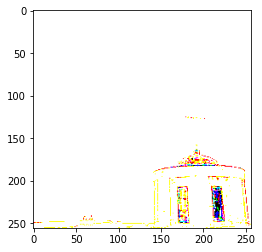

TypeError: can't multiply sequence by non-int of type 'float'

In [20]:
rgb_prediction = get_rgb_prediction_new('./data/images/Train/0AEYvu.jpg')
display(rgb_prediction)

In [8]:
color_me = []
n = 0
for filename in os.listdir('./data/testdata/Train/'):
    if (n < 1):
        color_me.append(img_to_array(load_img('./data/testdata/Train/'+filename)))
        n += 1

color_me = np.array(color_me, dtype=float)
gray_me = gray2rgb(rgb2gray(1.0/255*color_me))
color_me_embed = create_inception_embedding(gray_me)

color_me = rgb2lab(1.0/255*color_me)

color_me = color_me[:,:,:,0] / 100


color_me = color_me.reshape(color_me.shape+(1,))


# Test model

        
output = model.predict([color_me, color_me_embed])
output = output * 128

# Output colorizations
for i in range(len(output)):
    cur = np.zeros((256, 256, 3))
    cur[:,:,0] = color_me[i][:,:,0] * 100
    cur[:,:,1:] = output[i]
    print(output[i])
    
    ab_img = lab2rgb(cur)
    # display(ab_img)
    imsave("./results/V5_img_"+str(i)+".png", lab2rgb(cur))

/Users/justinalbert/.local/share/virtualenvs/Model-v_FdXyLj/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
[[[2.6960301 2.702037 ]
  [2.6960301 2.702037 ]
  [2.4265985 5.091251 ]
  ...
  [2.6683524 5.286791 ]
  [1.739714  6.734613 ]
  [1.739714  6.734613 ]]

 [[2.6960301 2.702037 ]
  [2.6960301 2.702037 ]
  [2.4265985 5.091251 ]
  ...
  [2.6683524 5.286791 ]
  [1.739714  6.734613 ]
  [1.739714  6.734613 ]]

 [[1.725727  6.064806 ]
  [1.725727  6.064806 ]
  [3.0665777 5.715419 ]
  ...
  [2.5130072 6.669859 ]
  [2.6031797 6.978017 ]
  [2.6031797 6.978017 ]]

 ...

 [[1.6482978 5.05698  ]
  [1.6482978 5.0

82.89451
0.0
40.846245
-14.154112


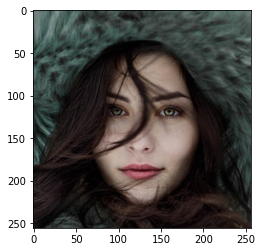

In [28]:
# THIS ONE WORKS THE BEST  
color_me = []
n = 0
for filename in os.listdir('./data/testdata/Train/'):
    if (n < 5):
        color_me.append(1.0/255 * img_to_array(load_img('./data/testdata/Train/'+filename)))
        n += 1
color_me = np.array(color_me)
# img = 1.0/255 * np.array(img_to_array(load_img('./data/images/Train/0AEYvu.jpg')))
img = color_me
img_display = color_me[0]

# img = img.astype('uint8')
# print(img.max())
# print(img.min())
# img_lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
img_lab = rgb2lab(img)
img_lab = img_lab[1]
l = img_lab[:, :, 0] 
ab = img_lab[:, :, 1:]
print(l.max())
print(l.min())
print(ab.max())
print(ab.min())
display(img_display)



99.6521
0.0
54.21875
-12.140625


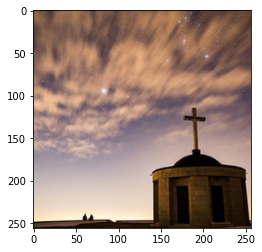

In [43]:
test_img = 1.0/255 * np.array(img_to_array(load_img('./data/images/Train/0AEYvu.jpg')))
#  test_img = cv2.imread('./data/images/Train/0AEYvu.jpg')
# rgb_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
img_lab = cv2.cvtColor(test_img, cv2.COLOR_RGB2LAB)


l = img_lab[:, :, 0]
ab = img_lab[:, :, 1:]

print(l.max())
print(l.min())
print(ab.max())
print(ab.min())

plt.imshow(test_img)